In [1]:
import os
import glob
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

# Batch effect (invasive cancer patches)

In [2]:
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)

In [3]:
aris_dict = {}

for model_type, names, benchmark_path in zip(
    [config['retrained_model_list1_type'], config['retrained_model_list2_type']],
    [config['retrained_model_list1'], config['retrained_model_list2']],
    [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):
    
    invasive_path = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans")
    opti_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)
    
    for model_name in names:
        n_clusters = opti_clusters.loc[model_name, "n_clusters"]        
        opti_json = os.path.join(invasive_path, model_name, f"scores_umap_across_parameters_{opti_clusters.loc[model_name, 'n_clusters']}_clusters.json")
        
        with open(opti_json, "r") as json_file:
            opti_params = json.load(json_file)
            
        filename = glob.glob(os.path.join(invasive_path, model_name, f"invasive_labels_{n_clusters}_clusters_umap_min_dist*.csv"))[0]
        min_dist = filename.split("min_dist_")[1].split("_n_neighbors")[0]
        n_neighbors = filename.split("n_neighbors_")[1].split(".csv")[0]
        mean_ari = opti_params[min_dist][n_neighbors]['ARI_patient']
        aris_dict[model_name] = 1-mean_ari

df_aris_invasive = pd.DataFrame.from_dict(aris_dict, orient='index')

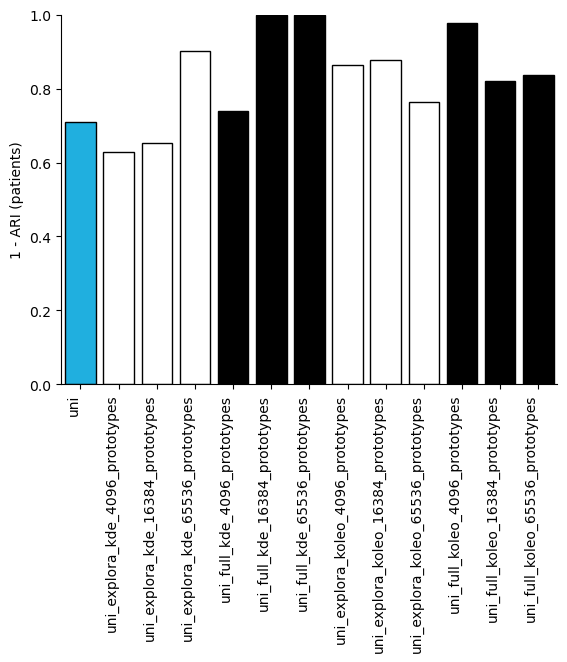

In [4]:
sorted_models = sort_retrained_models(config['retrained_model_list1'] + config['retrained_model_list2'])

palette = []
for model in sorted_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

sns.barplot(df_aris_invasive.T[sorted_models], palette=palette, edgecolor='black')
plt.ylim(0, 1)
plt.ylabel("1 - ARI (patients)")
plt.xticks(rotation=90, ha='right')
plt.savefig(os.path.join(config['figures_folder'], "Figure3", "batch_effect_invasive.pdf"), bbox_inches='tight')
sns.despine()